#### 1. Problema: Seleccionar una variable categórica como factor y una variable continua como variable dependiente

Supongan que están interesados en investigar si hay diferencias significativas en la variable dependiente entre al menos tres grupos que ustedes escojan de la base de datos del "Census at School".

**Pasos:**

1. **Análisis de Varianza (ANOVA)**: Primero, realizar un ANOVA para determinar si hay diferencias significativas en la variable dependiente entre los diferentes grupos. Deben proporcionar el código de cómo llegaron a las tablas de resumen y ANOVA (ver ejemplo en clase).
2. **Post-ANOVA**: Si el resultado del ANOVA es significativo, realizar un análisis post-hoc para determinar qué grupos específicos difieren en la variable dependiente. Usar la prueba LSD de Fisher.
3. **Intervalos de Confianza**: Calcular los intervalos de confianza para las diferencias en la variable dependiente entre los grupos. Esto les dará una idea de la incertidumbre asociada a las estimaciones de las diferencias.
4. **Gráficas**: Finalmente, visualizar los resultados utilizando un boxplot de la variable dependiente entre los diferentes grupos para visualizar las diferencias. También crear un gráfico de los intervalos de confianza para visualizar la incertidumbre de las estimaciones.

In [33]:
#import the necesari libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

In [34]:
df_alabama, df_florida, df_massachusetts = pd.read_csv("../data/rawdata/Alabama.csv", encoding="UTF-8"), pd.read_csv("../data/rawdata/Florida.csv", encoding="UTF-8"), pd.read_csv("../data/rawdata/Massachusetts.csv", encoding="UTF-8")
#Cargar los datos de los 3 datasets en python pandas

In [49]:
def Foot_to_centimeters(row): #Funcion para la estandarizacion y transformacion de los datos sobre la altura de los jovenes
    try:
        expresion = r"\d+" #expresion regular que usaremos para obtener todos los grupos de numeros de un string
        if type(row) is float:
            return row
        if ("'" in row) or ('"' in row) or ("/" in row): #Transforma los datos dados en pies a centimetros
            number = re.findall(expresion, row)
            if len(number) < 2:
                number = int(number[0])* 30.48
                return number
            number = int(number[0]) + int(number[1])/10
            number *= 30.48
            return number
        if ("cm" in row) or ("ft" in row): #saca los numeros cuando se han ingresado los datos con su unidad dde medida
            number = re.findall(expresion, row)
            if "ft in row":
                if len(number) < 2:
                    return number[0]*30.48
                return ((number[0])+(number[1]/10))*30.48
            return number[0]
        if "," in row and (len(re.findall(r"\d+", row)) == 2):# saca los numero cuando en vez de poner ' usan ,
            number = re.findall(expresion, row)
            number = int(number[0]) + int(number[1])
            number *= 30.48
            return number
        try:

            number = float(row)
            return number
        except ValueError:
            print(f"No es un número decimal : {row}")
    except Exception as err:
        print(f"fake : {row}")
        print(err)

IndentationError: expected an indented block after 'if' statement on line 17 (2859546344.py, line 18)

In [36]:
df_alabama.Height_cm = df_alabama.Height_cm.apply(Foot_to_centimeters)
df_florida["Height_cm"] = df_florida["Height_cm"].apply(Foot_to_centimeters)
df_massachusetts["Height_cm"] = df_florida["Height_cm"].apply(Foot_to_centimeters) #Aplicamos la transformacion de la columna a cada dataset

In [37]:
df_complete = pd.concat([df_florida, df_alabama, df_massachusetts]) #Hacemos la union de los datasets 

In [38]:
df_complete = df_complete[~df_complete["Height_cm"].isnull()] # Hacemos el dataset sin valores nulos en la columna de la altura

In [39]:
df_complete.Height_cm

0      182.0
1      163.0
2      182.0
3      183.5
4      175.0
       ...  
495     10.0
496      5.0
497    176.0
498    172.0
499    150.0
Name: Height_cm, Length: 1442, dtype: object

In [40]:
df_complete.shape

(1442, 60)

In [41]:
df_complete.reset_index(inplace=True)

In [42]:
df_complete.describe(include="object")

,Country,Region,Gender,Handed,Height_cm,Footlength_cm,Armspan_cm,Languages_spoken,Travel_to_School,Travel_time_to_School,...,Watching_TV_Hours,Paid_Work_Hours,Work_At_Home_Hours,Schoolwork_Pressure,Planned_Education_Level,Favorite_Music,Superpower,Preferred_Status,Role_Model_Type,Charity_Donation
count,1442,1442,1432,1423,1442.0,1384,1341,1404,1396,1401,...,1251,1245,1251,1218,1269,1270,1265,1267,1271,1277
unique,1,3,2,3,199.0,198,305,22,8,89,...,72,88,70,3,6,13,5,4,13,8
top,USA,AL,Male,Right-Handed,170.0,25,160,1,Car,15,...,0,0,1,Some,Graduate degree,Rap/Hip hop,Telepathy,Happy,Relative,Health
freq,1442,484,748,1213,67.0,132,53,899,1062,253,...,205,348,165,568,794,408,329,708,371,384


In [43]:
df_complete["Height_cm"] = df_complete.Height_cm.astype(float)

In [44]:
df_complete.describe()

,index,DataYear,ClassGrade,Ageyears,Height_cm
count,1442.000000,1442.000000,1442.000000,1436.000000,1442.000000
mean,248.465326,2018.658807,10.880028,86.713092,176.387340
std,144.317405,3.590810,1.996917,2638.552497,194.140389
min,0.000000,2010.000000,4.000000,0.000000,1.630000
25%,124.000000,2016.000000,11.000000,16.000000,160.000000
50%,248.000000,2019.000000,12.000000,17.000000,170.100000
75%,374.000000,2022.000000,12.000000,18.000000,179.000000
max,499.000000,2024.000000,12.000000,99999.000000,5000.000000


In [45]:
df_complete = df_complete[~df_complete["Planned_Education_Level"].isnull()]

In [46]:
df_complete = df_complete[df_complete["Height_cm"] < 220]
df_complete = df_complete [df_complete["Ageyears"] < 24]
df_complete = df_complete [df_complete["Height_cm"] > 100]

                                   sum_sq      df         F    PR(>F)
C(Planned_Education_Level)     862.910077     5.0  1.160429  0.326652
Residual                    175343.952025  1179.0       NaN       NaN
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------------------
      Graduate degree           High school   2.5906 0.3458  -1.1164  6.2976  False
      Graduate degree Less than high school  -3.3359 0.9795 -16.5544  9.8826  False
      Graduate degree                 Other  -0.9764 0.9876  -5.2997  3.3469  False
      Graduate degree          Some college    1.063 0.9607  -2.5654  4.6913  False
      Graduate degree  Undergraduate degree   0.4104 0.9989  -2.6542   3.475  False
          High school Less than high school  -5.9265 0.8155 -19.5362  7.6832  False
          High school             

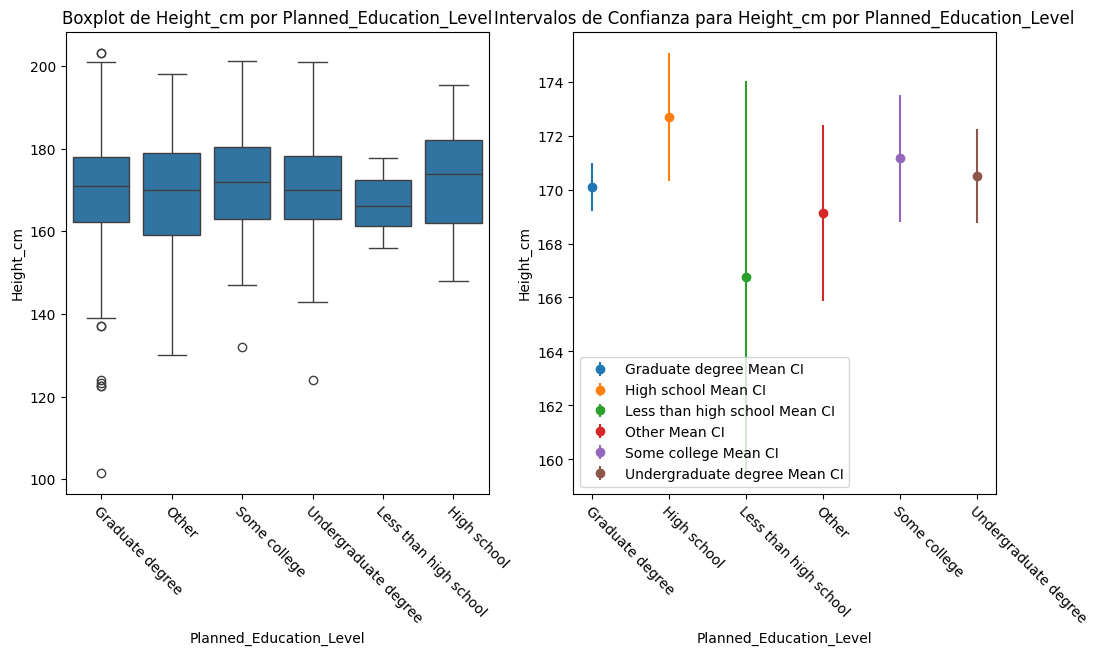

In [47]:
df_complete['Planned_Education_Level'] = df_complete['Planned_Education_Level'].astype('str')
df_complete['Height_cm'] = df_complete['Height_cm'].astype('float')

# Eliminar filas con valores NaN en las columnas relevantes
df_complete = df_complete.dropna(subset=['Planned_Education_Level', 'Height_cm'])

# ANOVA
model = ols('Height_cm ~ C(Planned_Education_Level)', data=df_complete).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Post-ANOVA (Prueba LSD de Fisher)
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df_complete['Height_cm'],
                          groups=df_complete['Planned_Education_Level'],
                          alpha=0.05)
print(tukey)

# Intervalos de Confianza
def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    m, se = data.mean(), stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return pd.Series([m, m-h, m+h], index=['mean', 'mean - h', 'mean + h'])

confidence_intervals = df_complete.groupby('Planned_Education_Level')['Height_cm'].apply(mean_confidence_interval).unstack()
print(confidence_intervals)

# Gráficas
plt.figure(figsize=(12, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='Planned_Education_Level', y='Height_cm', data=df_complete)
plt.title('Boxplot de Height_cm por Planned_Education_Level')
plt.setp(plt.subplot(1,2,1).get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor")

# Gráfico de Intervalos de Confianza
plt.subplot(1, 2, 2)
for level in confidence_intervals.index:
    plt.errorbar(level, confidence_intervals.loc[level, 'mean'], 
                 yerr=[[confidence_intervals.loc[level, 'mean'] - confidence_intervals.loc[level, 'mean - h']], 
                       [confidence_intervals.loc[level, 'mean + h'] - confidence_intervals.loc[level, 'mean']]], 
                 fmt='o', label=f'{level} Mean CI')
                 
plt.setp(plt.subplot(1,2,2).get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
plt.title('Intervalos de Confianza para Height_cm por Planned_Education_Level')
plt.xlabel('Planned_Education_Level')
plt.ylabel('Height_cm')
plt.legend()
plt.show()